# 00.Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from math import sqrt
from matplotlib import pyplot
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

2024-12-15 18:15:56.716493: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 18:15:56.720838: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-15 18:15:56.742943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 18:15:56.766524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 18:15:56.773917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 18:15:56.790325: I tensorflow/core/platform/cpu_feature_gu

# 01.Helpers

## 01.01 Constants

In [2]:
features_datasus = ['date', 'hospitalizations','average_stay', 'deaths', 'mortality_rate']

In [3]:
test_start_date = "2017-01-01"

In [4]:
features = ['date', 'hospitalizations', 'lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3']

## 01.02 Functions

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [6]:
def train_test_split(df, test_date, target_variable):
    # separação por tempo
    df_train = df[df.index < test_date]
    df_test  = df[df.index >= test_date]

    # remoção da variável target
    y_train = df_train[target_variable]
    y_test  = df_test[target_variable]

    df_train = df_train.drop(columns=target_variable).copy()
    df_test  = df_test.drop(columns=target_variable).copy()

    print(df_train.shape, y_train.shape)
    print(df_test.shape, y_test.shape)

    return df_train, df_test, y_train, y_test

In [7]:
def data_normalization(df_train, df_test, y_train, y_test):
    # Para as features
    scaler               = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled      = scaler.fit_transform(df_train)
    df_test_scaled       = scaler.transform(df_test)

    # Para a variável alvo
    scaler_target       = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled      = scaler_target.fit_transform(y_train.to_frame())
    y_test_scaled       = scaler_target.transform(y_test.to_frame())

    print(df_train_scaled.shape, y_train_scaled.shape)
    print(df_test_scaled.shape, y_test_scaled.shape)

    return scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled

In [8]:
def data_reconversion(scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled, y_pred):
    df_train_original = scaler.inverse_transform(df_train_scaled)
    df_test_original = scaler.inverse_transform(df_test_scaled)

    y_train_original = scaler_target.inverse_transform(y_train_scaled)
    y_test_original = scaler_target.inverse_transform(y_test_scaled)
    y_pred_original = scaler_target.inverse_transform(y_pred)

    return df_train_original, df_test_original, y_train_original, y_test_original, y_pred_original

In [9]:
def metrics(y, predicted):
    mae = mean_absolute_error(y, predicted)
    mse = mean_squared_error(y, predicted)
    rmse = np.sqrt(mean_squared_error(y, predicted))
    mape = np.mean(np.abs((y - predicted) / y)) * 100
    r2 = r2_score(y, predicted)
    return mae, mse, rmse, mape, r2

def print_metrics(y, predicted):
    mae, mse, rmse, mape, r2 = metrics(y, predicted)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-Squared (R²): {r2:.2f}")

In [10]:
def build_model(hp):
    model = Sequential()
    # LSTM layers with variable number of units
    model.add(LSTM(units=hp.Int('units_layer1', min_value=10, max_value=100, step=5), input_shape=(train_X.shape[1], train_X.shape[2])))
    # model.add(LSTM(units=hp.Int('units_layer2', min_value=10, max_value=100, step=5), return_sequences=True))
    # model.add(LSTM(units=hp.Int('units_layer3', min_value=10, max_value=100, step=5)))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

In [11]:
def permutation_importance(model, X_test, y_test, metric=mean_squared_error):
    """
    Calculates feature importance using Permutation Importance.
    
    Parameters:
        model: Trained model (e.g., LSTM).
        X_test: Test data (shape: samples, timesteps, features).
        y_test: Ground truth values corresponding to the test set.
        metric: Metric function to evaluate the model's performance.
    
    Returns:
        importances: Calculated importance for each feature.
    """
    baseline_score = metric(y_test, model.predict(X_test))  # Original performance score
    importances = []

    # Iterate over each feature
    for i in range(X_test.shape[2]):
        X_test_permuted = X_test.copy()

        # Permute the values of feature i while maintaining the temporal structure
        for j in range(X_test.shape[0]):  # For each sample
            np.random.shuffle(X_test_permuted[j, :, i])

        # Calculate the new performance score
        permuted_score = metric(y_test, model.predict(X_test_permuted))

        # Importance = difference between the original and permuted performance scores
        importance = permuted_score - baseline_score
        importances.append(importance)
    
    return np.array(importances)

In [12]:
# Assume 'importances' contains the feature importances and 'feature_names' the names of the features
def plot_permutation_importance(importances, feature_names):
    """
    Plots feature importances as a bar chart.
    
    Parameters:
        importances: Calculated importance for each feature (array).
        feature_names: List containing the names of the features.
    """
    # Sort the importances and feature names
    sorted_idx = np.argsort(importances)  # Indices of the sorted importances
    sorted_importances = importances[sorted_idx]
    sorted_features = [feature_names[i] for i in sorted_idx]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color="skyblue")
    plt.xlabel("Feature Importance (Permutation)")
    plt.title("Permutation Feature Importance for LSTM Model")
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.show()

# 02.Importing Datasets

In [13]:
dataset = pd.read_csv('../../Preprocessing/dataset.csv', 
                   header=0, 
                   index_col=0,
                   usecols=features)

dataset

,hospitalizations,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
date,,,,
2000-12-01,4266.0,21.132403,19.318992,15.300694
2001-01-01,4032.0,24.154261,21.132403,19.318992
2001-02-01,3888.0,26.316156,24.154261,21.132403
2001-03-01,3658.0,27.119464,26.316156,24.154261
2001-04-01,4022.0,26.113387,27.119464,26.316156
...,...,...,...,...
2024-05-01,3172.0,22.136556,25.621075,27.636221
2024-06-01,3640.0,16.708185,22.136556,25.621075
2024-07-01,3689.0,17.283889,16.708185,22.136556


In [14]:
dataset.columns

Index(['hospitalizations', 'lag_heat_index_1', 'lag_heat_index_2',
       'lag_heat_index_3'],
      dtype='object')

# 03.Preprocessing

## 03.01 Remoção ano 2000

In [15]:
dataset = dataset[dataset.index < "2020-01-01"]

dataset.index = pd.to_datetime(dataset.index)

test_start_date = '2017-01-01'

dataset.head(5)

,hospitalizations,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
date,,,,
2000-12-01,4266.0,21.132403,19.318992,15.300694
2001-01-01,4032.0,24.154261,21.132403,19.318992
2001-02-01,3888.0,26.316156,24.154261,21.132403
2001-03-01,3658.0,27.119464,26.316156,24.154261
2001-04-01,4022.0,26.113387,27.119464,26.316156


# 04.Model training

## 04.01 Split train and test

In [16]:
df_train, df_test, y_train, y_test = train_test_split(dataset, test_start_date, 'hospitalizations')

(193, 3) (193,)
(36, 3) (36,)


## 04.02 Normalization

In [17]:
scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled = data_normalization(df_train, df_test, y_train, y_test)

(193, 3) (193, 1)
(36, 3) (36, 1)


## 04.03 Reshape input to be 3D [samples, timesteps, features]

In [18]:
train_X = df_train_scaled.reshape((df_train_scaled.shape[0], 1, df_train_scaled.shape[1]))
test_X = df_test_scaled.reshape((df_test_scaled.shape[0], 1, df_test_scaled.shape[1]))

print(train_X.shape, y_train_scaled.shape, test_X.shape, y_test_scaled.shape)

(193, 1, 3) (193, 1) (36, 1, 3) (36, 1)


## 04.04 Recurrent network

In [19]:
# Configuring Random Search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Number of combinations to be tested
    executions_per_trial=5,
    directory='my_dir_timelags_only',
    project_name='lstm_tuning'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Perform the search
tuner.search(train_X, y_train_scaled, epochs=50, validation_data=(test_X, y_test_scaled), callbacks=[early_stopping])

# Best set of hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Better number of LSTM units in the first layer: {best_hps.get('units_layer1')}")
print(f"Melhor taxa de aprendizado: {best_hps.get('learning_rate')}")

Trial 10 Complete [00h 00m 23s]
val_loss: 0.0185325238853693

Best val_loss So Far: 0.01718257777392864
Total elapsed time: 00h 05m 41s
Better number of LSTM units in the first layer: 45
Melhor taxa de aprendizado: 0.01


### 04.04.01 Final Model

Epoch 1/150
17/17 - 2s - 123ms/step - loss: 0.1421 - val_loss: 0.0297
Epoch 2/150
17/17 - 0s - 5ms/step - loss: 0.0710 - val_loss: 0.0296
Epoch 3/150
17/17 - 0s - 5ms/step - loss: 0.0625 - val_loss: 0.0381
Epoch 4/150
17/17 - 0s - 5ms/step - loss: 0.0483 - val_loss: 0.0274
Epoch 5/150
17/17 - 0s - 6ms/step - loss: 0.0505 - val_loss: 0.0286
Epoch 6/150
17/17 - 0s - 5ms/step - loss: 0.0468 - val_loss: 0.0257
Epoch 7/150
17/17 - 0s - 5ms/step - loss: 0.0463 - val_loss: 0.0250
Epoch 8/150
17/17 - 0s - 5ms/step - loss: 0.0454 - val_loss: 0.0243
Epoch 9/150
17/17 - 0s - 6ms/step - loss: 0.0447 - val_loss: 0.0241
Epoch 10/150
17/17 - 0s - 6ms/step - loss: 0.0441 - val_loss: 0.0241
Epoch 11/150
17/17 - 0s - 5ms/step - loss: 0.0436 - val_loss: 0.0241
Epoch 12/150
17/17 - 0s - 5ms/step - loss: 0.0431 - val_loss: 0.0243
Epoch 13/150
17/17 - 0s - 5ms/step - loss: 0.0427 - val_loss: 0.0245
Epoch 14/150
17/17 - 0s - 5ms/step - loss: 0.0424 - val_loss: 0.0247
Epoch 15/150
17/17 - 0s - 5ms/step - loss

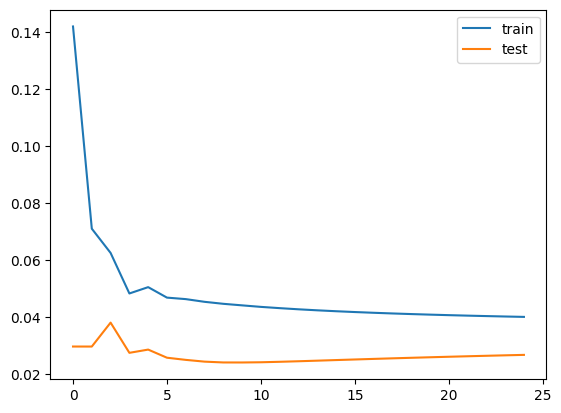

In [20]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

optimizer = Adam(learning_rate=0.01)

# design network
model = Sequential()
model.add(LSTM(45, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer=optimizer)

# fit network
history = model.fit(train_X, 
                    y_train_scaled, 
                    epochs=150, 
                    batch_size=12, 
                    validation_data=(test_X, y_test_scaled), 
                    verbose=2, 
                    callbacks=[early_stopping],
                    shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 45)             │         8,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            46 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,600 (103.91 KB)

 Trainable params: 8,866 (34.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,734 (69.28 KB)

### 04.04.02 Permutation Feature importance

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Feature 0: Importance = 0.0000
Feature 1: Importance = 0.0000
Feature 2: Importance = 0.0000


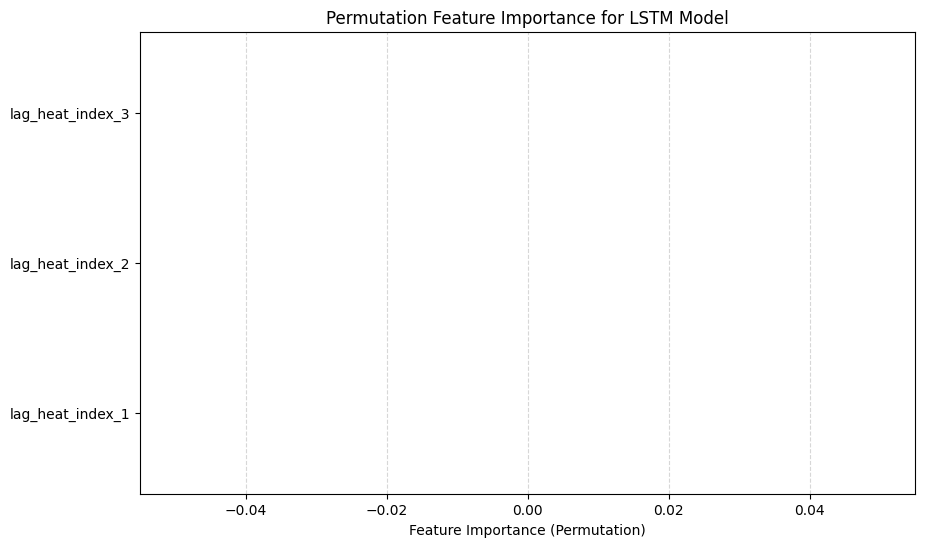

In [22]:
# Exemplo de uso com um modelo LSTM
# Suponha que X_test tenha o formato (samples, timesteps, features)
importances = permutation_importance(model, test_X, y_test_scaled)

# # Exibindo as importâncias
for idx, imp in enumerate(importances):
    print(f"Feature {idx}: Importance = {imp:.4f}")

# Exemplo de uso
feature_names = df_test.columns

# Chamando a função para plotar
plot_permutation_importance(importances, feature_names)

### 04.04.03 Prediction

In [23]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
y_pred = np.concatenate((yhat, test_X[:, 1:]), axis=1)
y_pred = scaler_target.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = y_test_scaled.reshape((len(y_test_scaled), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler_target.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
print_metrics(inv_y, y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Absolute Error (MAE): 261.58
Mean Squared Error (MSE): 89688.61
Root Mean Squared Error (RMSE): 299.48
Mean Absolute Percentage Error (MAPE): 8.27%
R-Squared (R²): -1.27


### 04.04.04 Plot

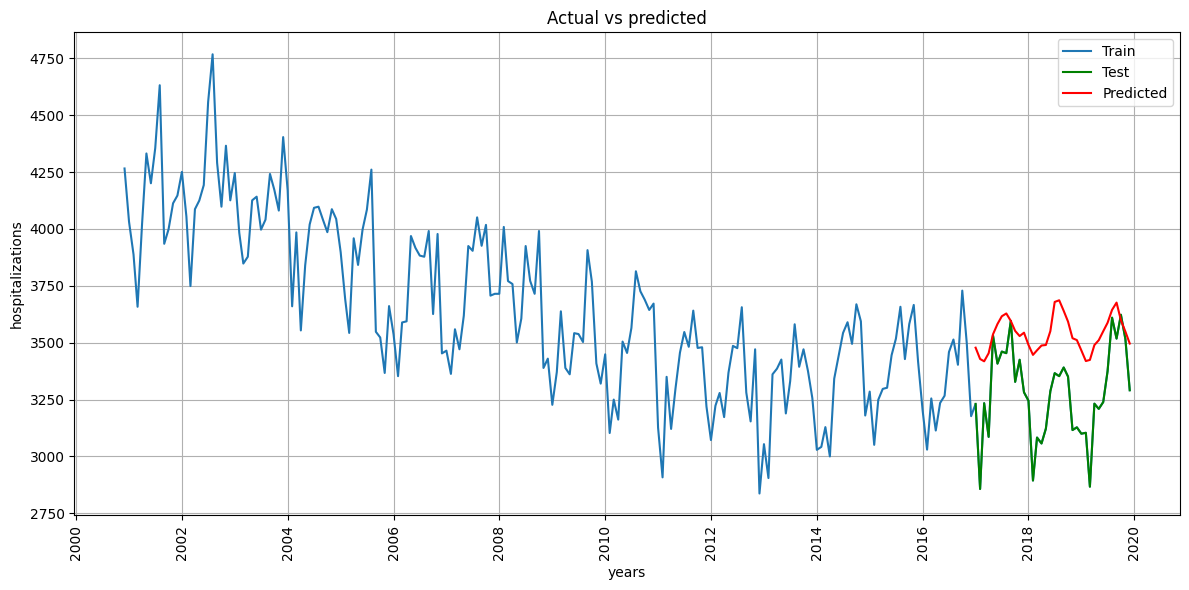

In [24]:
index_train = pd.to_datetime(dataset.index)
index_test = dataset.tail(len(y_pred)).index

plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['hospitalizations'], label='Train')
plt.plot(index_test, inv_y, color='green', label='Test')
plt.plot(index_test, y_pred, color='red', label='Predicted')
plt.title("Actual vs predicted")
plt.xlabel('years')
plt.ylabel('hospitalizations')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()